<a href="https://colab.research.google.com/github/ArnavKetkar/PortfolioProjects/blob/main/TransformerEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install transformers

Encoder for Transformer



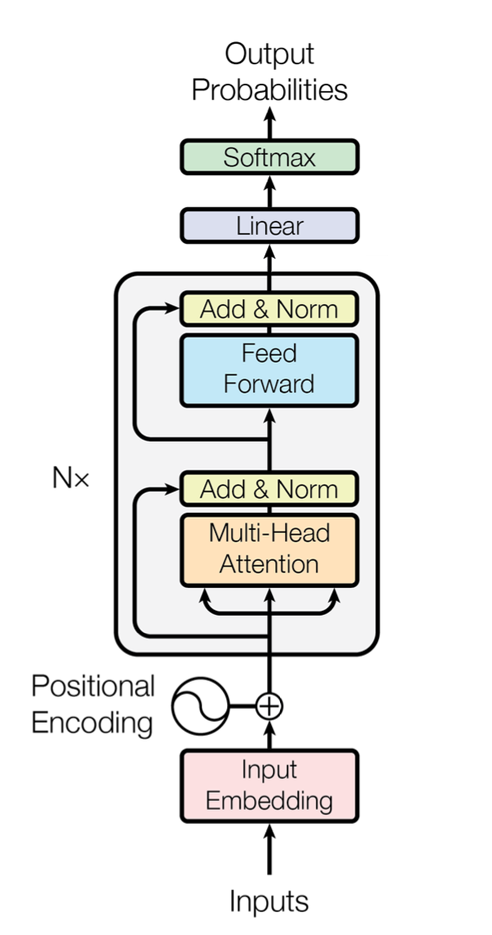

Tokenization

In [ ]:
import pandas as pd
from transformers import AutoTokenizer

chkpnt = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(chkpnt)

In [ ]:
tokenizer('Hello, how do you do')

{'input_ids': [101, 7592, 1010, 2129, 2079, 2017, 2079, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}

In [ ]:
text = 'This is what tokenization is like.'

tokenized_text = {}
tokenized_text['Numerical Token'] = tokenizer(text)['input_ids']
tokenized_text['Tokens'] = tokenizer.convert_ids_to_tokens(tokenizer(text)['input_ids'])

print("Tokenizer has a vocabulary size of", tokenizer.vocab_size, "words.")
print("Tokenizer has a maximum sequence length of", tokenizer.model_max_length, "tokens.")
pd.DataFrame(tokenized_text).T

Tokenizer has a vocabulary size of 30522 words.
Tokenizer has a maximum sequence length of 512 tokens.


0     1     2     3      4          5     6     7     8  \
Numerical Token    101  2023  2003  2054  19204       3989  2003  2066  1012   
Tokens           [CLS]  this    is  what  token  ##ization    is  like     .   

                     9  
Numerical Token    102  
Tokens           [SEP]

In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
device

device(type='cuda')

Config Dict to define model parameters

In [ ]:
class Config:
  def __init__(self, config_dict):
    self.__dict__.update(config_dict)

#Setting arameters for model
config = {
    'vocab_size' : tokenizer.vocab_size,
    'embedding_dimensions' : 128,
    'max_tokens' : 100, #max 100 tokens per input seq
    'num_attention_heads' : 8,
    'hidden_dropout_prob' : 0.3, #For FeedForwardNet
    'intermediate_size' : 128*4, #Number of neurons in intermediate layer of FFN
    'num_encoder_blocks' : 2,
    'device' : device
}

config = Config(config)

In [ ]:
import torch.nn as nn

class TokenEmbedding(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.token_embedding = nn.Embedding(num_embeddings=config.vocab_size, embedding_dim=config.embedding_dimensions)

  def forward(self, tokenized_sent):
    return self.token_embedding(tokenized_sent)

token_embedding = TokenEmbedding(config).to(config.device)

sent = 'Hello, how do you do?'
input_seq = tokenizer.encode_plus(sent, return_tensors='pt', padding='max_length', truncation=True, max_length=100)['input_ids']
input_seq = input_seq.to(config.device)

embedding_output = token_embedding(input_seq)
print(embedding_output.size())

torch.Size([1, 100, 128])


Postional Encodings

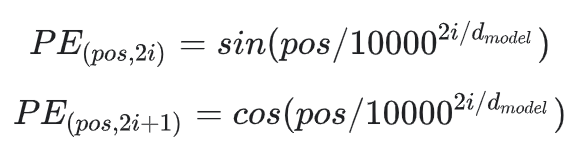

In [ ]:
class PostionalEncoding(nn.Module):
  def __init__(self, config):
    super().__init__()
    pe = torch.zeros(config.max_tokens, config.embedding_dimensions)
    position = torch.arange(0, config.max_tokens, dtype=torch.float).unsqueeze(1)
    div_term = 1 / (10000 ** (torch.arange(0, config.embedding_dimensions, 2).float() / config.embedding_dimensions))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)

    self.pe = pe.unsqueeze(0).transpose(0, 1)
    self.pe = self.pe.to(config.device)

  def forward(self, x):
    return x + self.pe[:, 0]

positional_encoding = PostionalEncoding(config).to(config.device)

In [ ]:
#Check that above module is working:
pos_enc_out = positional_encoding(embedding_output)
print(pos_enc_out.size())


torch.Size([1, 100, 128])


Visualizing Self Attention

In [ ]:
#!pip install bertviz

In [ ]:
from bertviz.transformers_neuron_view import BertModel
from bertviz.neuron_view import show

model = BertModel.from_pretrained(chkpnt)

In [ ]:
text = 'bat in the cave.'
show(model, 'bert', tokenizer, text, display_mode='light', layer=0, head=8)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
text = 'bat hit the ball.'
show(model, 'bert', tokenizer, text, display_mode='light', layer=0, head=8)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Implementing Multi Head attention:

In [ ]:
import torch.nn.functional as F
import numpy as np

def scaled_dot_product_attention(q, k, v):
  d_k = k.size(-1)
  align_scores = torch.bmm(q, k.transpose(1, 2))/np.sqrt(d_k)
  weights = F.softmax(align_scores, dim=-1)
  return torch.bmm(weights, v)

class AttentionHead(nn.Module):
  def __init__(self, embed_dim, head_dim):
    super().__init__()
    self.k = nn.Linear(embed_dim, head_dim)
    self.q = nn.Linear(embed_dim, head_dim)
    self.v = nn.Linear(embed_dim, head_dim)

  def forward(self, hidden_state):
    attn_wts = scaled_dot_product_attention(self.q(hidden_state), self.k(hidden_state), self.v(hidden_state))
    return attn_wts

class MultiHeadAttention(nn.Module):
  def __init__(self, config):
    super().__init__()
    embed_dim = config.embedding_dimensions
    num_heads = config.num_attention_heads
    head_dim = embed_dim // num_heads
    self.heads = nn.ModuleList(
        [AttentionHead(embed_dim, head_dim) for _ in range(num_heads)]
        )
    self.linear_output = nn.Linear(embed_dim, embed_dim)

  def forward(self, hidden_state):
    x = torch.cat([h(hidden_state) for h in self.heads], dim=-1)
    x = self.linear_output(x)
    return x

multi_head_attn = MultiHeadAttention(config).to(config.device)

In [ ]:
attn_output = multi_head_attn(pos_enc_out)
print("Shape of output:", attn_output.size())
print("Number of heads:", len(MultiHeadAttention(config).heads))
multi_head_attn.heads[:2]

Shape of output: torch.Size([1, 100, 128])
Number of heads: 8


ModuleList(
  (0-1): 2 x AttentionHead(
    (k): Linear(in_features=128, out_features=16, bias=True)
    (q): Linear(in_features=128, out_features=16, bias=True)
    (v): Linear(in_features=128, out_features=16, bias=True)
  )
)

Residual Connections and Layer Norm

In [ ]:
x = pos_enc_out

layer_norm = nn.LayerNorm(config.embedding_dimensions).to(config.device)

add_norm_out = layer_norm(x + multi_head_attn(x))
add_norm_out.size()

torch.Size([1, 100, 128])

Feed-Forward Network

In [ ]:
class FeedForward(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.linear1 = nn.Linear(config.embedding_dimensions, config.intermediate_size)
    self.linear2 = nn.Linear(config.intermediate_size, config.embedding_dimensions)
    self.gelu = nn.GELU()
    self.dropout = nn.Dropout(p=config.hidden_dropout_prob)

  def forward(self, x):
    out = self.linear1(x)
    out = self.gelu(out)
    out = self.linear2(out)
    out = self.dropout(out)
    return out

feed_forward = FeedForward(config).to(config.device)

In [ ]:
ffn_output = feed_forward(add_norm_out)
ffn_output.size()

torch.Size([1, 100, 128])

In [ ]:
x = add_norm_out

layer_norm = nn.LayerNorm(config.embedding_dimensions).to(config.device)

add_norm_out2 = layer_norm(x + feed_forward(x))
add_norm_out2.size()

torch.Size([1, 100, 128])

Pre LN

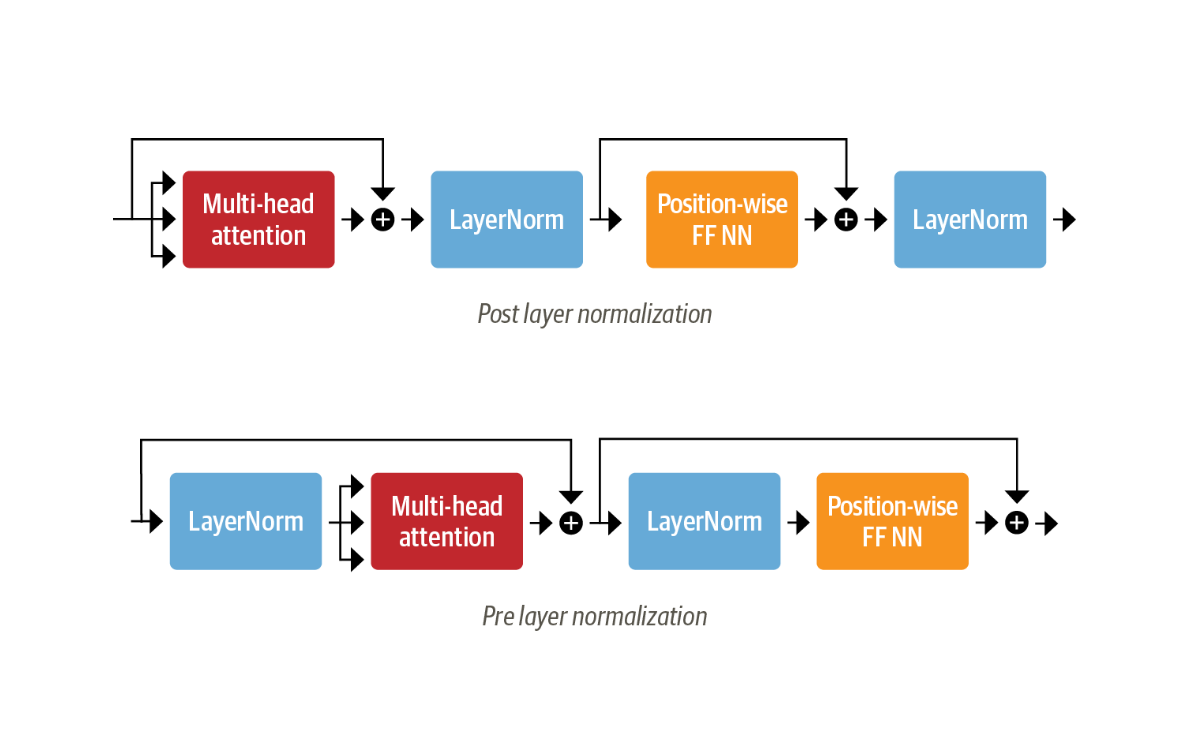

In [ ]:
class PostLNEncoder(nn.Module):
  def __init__(self, config):
    super().__init()
    self.multi_head_attn = MultiHeadAttention(config)
    self.layer_norm1 = nn.LayerNorm(config.embedding_dimensions)
    self.layer_norm2 = nn.LayerNorm(config.embedding_dimensions)
    self.feed_forward = FeedForward(config)

  def forward(self, x):
      x = self.layer_norm1(x + self.multi_head_attn(x))
      x = self.layer_norm2(x + self.feed_forward(x))
      return x

In [ ]:
class Encoder(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.multi_head_attn = MultiHeadAttention(config)
    self.layer_norm1 = nn.LayerNorm(config.embedding_dimensions)
    self.layer_norm2 = nn.LayerNorm(config.embedding_dimensions)
    self.feed_forward = FeedForward(config)

  def forward(self, x):
      x1 = x + self.multi_head_attn(self.layer_norm1(x))
      x2 = self.layer_norm2(x1)
      x2 = self.feed_forward(x2)
      x2 = x1+x2
      return x2

encoder = Encoder(config).to(config.device)

In [ ]:
enc_out = encoder(pos_enc_out)
print(enc_out.size())

torch.Size([1, 100, 128])


Classifier Head

In [ ]:
class ClassifierHead(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.flatten = nn.Flatten()
    self.linear1 = nn.Linear(config.max_tokens*config.embedding_dimensions, 2*config.embedding_dimensions)
    self.relu = nn.ReLU()
    self.linear2 = nn.Linear(2*config.embedding_dimensions, 1)

  def forward(self, x):
    x = self.flatten(x)
    x = self.linear1(x)
    x = self.relu(x)
    x = self.linear2(x)
    return torch.sigmoid(x)

classifier = ClassifierHead(config).to(config.device)

In [ ]:
pred = classifier(enc_out)
print(pred.size())
print(pred.item())

torch.Size([1, 1])
0.3573336601257324


In [29]:
class Transformer(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.embedding = TokenEmbedding(config)
    self.pos_encoding = PostionalEncoding(config)
    self.encoders = nn.ModuleList([Encoder(config) for _ in range(config.num_encoder_blocks)])
    self.classifier = ClassifierHead(config)

  def forward(self, x):
    x = self.embedding(x)
    x = self.pos_encoding(x)
    for encoder in self.encoders:
      x = encoder(x)
    x = classifier(x)
    return x

transformer = Transformer(config).to(config.device)

In [30]:
pred = transformer(input_seq)
print(pred.item())

0.49978646636009216


Training the Model

In [36]:
train_path = '/content/train.csv'
test_path = '/content/test.csv'

df = pd.read_csv(train_path, index_col=0, usecols=['id', 'text', 'target'])
df.head()

text  target
id                                                           
1   Our Deeds are the Reason of this #earthquake M...       1
4              Forest fire near La Ronge Sask. Canada       1
5   All residents asked to 'shelter in place' are ...       1
6   13,000 people receive #wildfires evacuation or...       1
7   Just got sent this photo from Ruby #Alaska as ...       1

In [37]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

Initializing Tokenizer

In [39]:
model_checkpoint = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

text = train_df.iloc[42]['text']

tokenized_text = {}
tokenized_text['Numerical Token'] = tokenizer(text)['input_ids']
tokenized_text['Tokens'] = tokenizer.convert_ids_to_tokens(tokenizer(text)['input_ids'])

print("Tokenizer has a vocabulary size of", tokenizer.vocab_size, "words.")
print("Tokenizer has a maximum sequence length of", tokenizer.model_max_length, "tokens.")
pd.DataFrame(tokenized_text).T

Tokenizer has a vocabulary size of 30522 words.
Tokenizer has a maximum sequence length of 512 tokens.


0     1     2      3     4     5      6     7     8   \
Numerical Token    101  3915  3406  10259  1024  2006   2651  1005  1055   
Tokens           [CLS]   usa  ##to  ##day     :    on  today     '     s   

                   9   ...    43    44    45    46     47    48    49    50  \
Numerical Token  1001  ...  2522  1013  1019  6968  11631  2243  2581  6499   
Tokens              #  ...    co     /     5  ##uk   ##oh   ##k   ##7  ##so   

                   51     52  
Numerical Token  2497    102  
Tokens            ##b  [SEP]  

[2 rows x 53 columns]

Tokenization

In [40]:
max_length = config.max_tokens

def tokenize_row(row, max_length):
  text = row['text']
  tokenized = tokenizer.encode_plus(text, padding='max_length', max_length=max_length, truncation=True)
  return tokenized['input_ids']

train_df['tokenized'] = train_df.apply(lambda row: tokenize_row(row, max_length), axis=1)
val_df['tokenized'] = val_df.apply(lambda row: tokenize_row(row, max_length), axis=1)

train_df.head()

text  target  \
id                                                                
7128  Courageous and honest analysis of need to use ...       1   
4688  @ZachZaidman @670TheScore wld b a shame if tha...       0   
6984  Tell @BarackObama to rescind medals of 'honor'...       1   
4103  Worried about how the CA drought might affect ...       1   
6706  @YoungHeroesID Lava Blast &amp; Power Red #Pan...       0   

                                              tokenized  
id                                                       
7128  [101, 26103, 1998, 7481, 4106, 1997, 2342, 200...  
4688  [101, 1030, 12397, 25290, 21804, 1030, 25535, ...  
6984  [101, 2425, 1030, 13857, 16429, 8067, 2000, 24...  
4103  [101, 5191, 2055, 2129, 1996, 6187, 14734, 245...  
6706  [101, 1030, 2402, 5886, 22504, 3593, 13697, 84...

Preparing DataLoader

In [52]:
from torch.utils.data import Dataset, DataLoader

X_train = train_df.tokenized
y_train = train_df.target

X_val = val_df.tokenized
y_val = val_df.target

class TextDataset(Dataset):
  def __init__(self, x_df, y_df):
    self.x_df = x_df
    self.y_df = y_df

  def __len__(self):
    return len(self.x_df)

  def __getitem__(self, idx):
    x = self.x_df.iloc[idx]
    y = self.y_df.iloc[idx]
    return torch.LongTensor(x), torch.tensor(y, dtype=torch.float32)

train_dataset = TextDataset(X_train, y_train)
val_dataset = TextDataset(X_val, y_val)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)

Training Loop

In [53]:
model = Transformer(config).to(config.device)
loss_func = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
model = model.to(config.device)

n_epochs = 8

metrics = {
    'train_loss' : [],
    'train_accuracy' : [],
    'val_loss' : [],
    'val_accuracy' : []
}

In [54]:
for epoch in range(n_epochs):
  for i, (inputs, targets) in enumerate(train_dataloader):
    inputs = inputs.to(config.device)
    targets = targets.to(config.device)

    model.train()

    #Clear gradients
    optimizer.zero_grad()

    #Forward Pass
    outputs = model(inputs)

    #Calculate Loss
    train_loss = loss_func(outputs.squeeze(), targets)

    #Backward Prop
    train_loss.backward()
    optimizer.step()

    #Calculating Metrics
    train_preds = (outputs.squeeze().detach().cpu()>0.5)
    train_accuracy = (train_preds == targets.cpu()).type(torch.float).mean().item()

    #Validation Loop
    if i%20==0:
      model.eval()
      with torch.no_grad():
        val_losses =  []
        val_accuracies = []
        for val_inputs, val_targets in val_dataloader:
          val_inputs = val_inputs.to(config.device)
          val_targets = val_targets.to(config.device)

          val_outputs = model(val_inputs)
          val_loss = loss_func(val_outputs.squeeze(), val_targets)
          val_losses.append(val_loss.item())

          val_predictions = (val_outputs.squeeze().detach().cpu() > 0.5)
          val_accuracy = (val_predictions == val_targets.cpu()).type(torch.float).mean().item()
          val_accuracies.append(val_accuracy)

      #Get mean loss and accuracy over validation set
      val_loss = np.mean(val_losses)
      val_accuracy = np.mean(val_accuracy)

      #Store Metrics
      metrics['train_loss'].append(train_loss.item())
      metrics['train_accuracy'].append(train_accuracy)
      metrics['val_loss'].append(val_loss)
      metrics['val_accuracy'].append(val_accuracy)

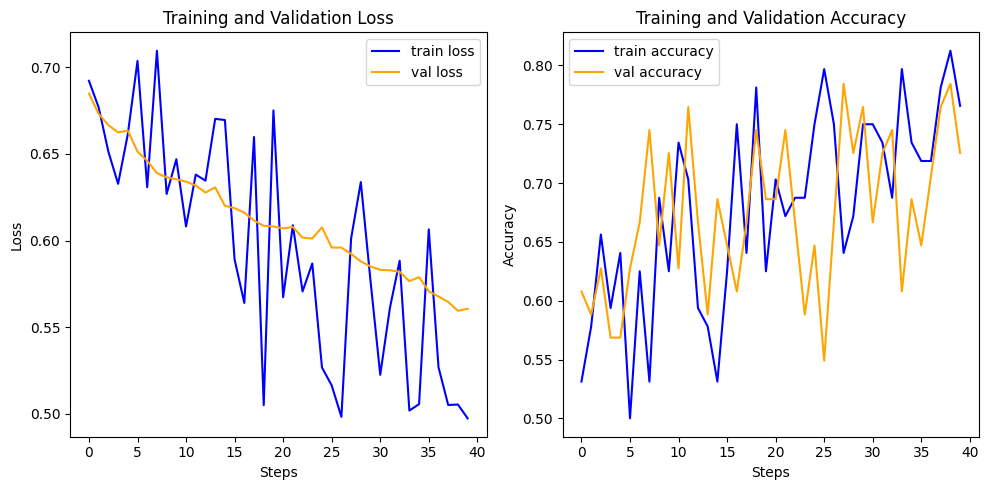

In [57]:
#Plot Graphs
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

ax[0].plot(metrics['train_loss'], color='blue', label='train loss')
ax[0].plot(metrics['val_loss'], color='orange', label='val loss')
ax[0].set_title('Training and Validation Loss')
ax[0].set_xlabel('Steps')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(metrics['train_accuracy'], color='blue', label='train accuracy')
ax[1].plot(metrics['val_accuracy'], color='orange', label='val accuracy')
ax[1].set_title('Training and Validation Accuracy')
ax[1].set_xlabel('Steps')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.tight_layout()
plt.show()